# SageMaker Tune in action

In this notebook, we will show how to tune hyperparameters with Sagemaker Tune. In particular, we will show how to tune the hyperparameters of a computer-vision model on a local machine and then on SageMaker with many more machines.

## Setup

In [ ]:
cd /home/ec2-user/SageMaker/sagemaker-tune

In [ ]:
# temporary note need ssh key since the repo is private or manual upload.
!git clone git@github.com:awslabs/sagemaker-tune.git

In [ ]:
!git checkout blog

In [ ]:
!git pull

In [ ]:
!pip install -e .[extra]

In [1]:
cd /home/ec2-user/SageMaker/sagemaker-tune/blog-post/

/home/ec2-user/SageMaker/sagemaker-tune/blog-post


## How to enable tuning


To tune hyperparameters, you will need: 
* 1) a main script that takes hyperparameters as arguments
* 2) to add one line to report results once they are obtained

Let us take a look at a simplified example of a script that has learning_rate, dropout_rate as hyperparameters and report accuracy over the training epochs.

```python
from argparse import ArgumentParser
from sagemaker_tune.report import Reporter

if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument('--learning_rate', type=float)
    parser.add_argument('--dropout_rate', type=float)

    args, _ = parser.parse_known_args()
    report = Reporter()

    for epoch in range(args.epochs):
        # ... train model and get accuracy        
        accuracy = compute_accuracy()
        
        # Feed the score back to Sagemaker Tune.
        report(epoch=epoch, accuracy=accuracy)
```

In our case, we are going to use a slightly more complex case that trains a computer-vision model adapted from Sagemaker examples [[link]](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/pytorch_cnn_cifar10/source/cifar10.py).

Let us have a look to the full code of the example.

In [ ]:
!pygmentize source/train_cifar10.py

Since the example requires cifar10 dataset, we first download it locally.

In [5]:
from utils_cifar import get_train_data_loader, get_test_data_loader, imshow, classes, get_train_data_loader_cifar100, get_test_data_loader_cifar100

# trainloader = get_train_data_loader()
# testloader = get_test_data_loader()

trainloader = get_train_data_loader_cifar100()
testloader = get_test_data_loader_cifar100()

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


0it [00:00, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


We are now all settled to launch tuning of hyperparameters in this particular case.

The following code defines the search space for the hyperparameters (dropout, learning-rate, momentum) and the scheduler being used (Hyperband).

In [9]:
import logging
logging.getLogger().setLevel(logging.INFO)
from sagemaker_tune.backend.local_backend import LocalBackend
from sagemaker_tune.tuner import Tuner
from sagemaker_tune.search_space import loguniform, uniform
from sagemaker_tune.stopping_criterion import StoppingCriterion
from sagemaker_tune.optimizer.schedulers.hyperband import HyperbandScheduler


max_epochs = 27
config_space = {
    "epochs": max_epochs,
    "lr": loguniform(1e-5, 1e-1),
    "momentum": uniform(0.8, 1.0),
    "dropout_rate": loguniform(1e-5, 1.0),
}


scheduler = HyperbandScheduler(
    config_space,
    max_t=max_epochs,
    resource_attr='epoch',
    searcher='random',
    metric="val_acc",
    mode="max",
)

We are now ready to define and launch the tuning of our hyperparameters.

To do so, we define the number of workers that evaluates trials concurrently and how long we are willing to wait.

Importantly, we use the local backend to evaluate our training script `"source/train_cifar10.py"`. This means that the tuning will run on the local machine with one subprocess per worker.

In [10]:
tuner = Tuner(
    backend=LocalBackend(entry_point="source/train_cifar100.py"),
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(max_wallclock_time=7200),
    n_workers=4,
)

tuner.run()


INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/train-cifar100-2021-11-15-11-03-07-061
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[0: random]
lr: 0.0010000000000000002
momentum: 0.9
dropout_rate: 0.003162277660168379
INFO:sagemaker_tune.optimizer.schedulers.hyperband:trial_id 0 starts (first milestone = 1)
INFO:root:Detected 4 GPUs
INFO:root:running subprocess with command: /home/ec2-user/anaconda3/envs/pytorch_p36/bin/python source/train_cifar100.py --epochs 27 --lr 0.0010000000000000002 --momentum 0.9 --dropout_rate 0.003162277660168379 --smt_checkpoint_dir /home/ec2-user/sagemaker-tune/train-cifar100-2021-11-15-11-03-07-061/0/checkpoints
INFO:sagemaker_tune.tuner:(trial 0) - scheduled config {'epochs': 27, 'lr': 0.0010000000000000002, 'momentum': 0.9, 'dropout_rate': 0.003162277660168379}
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[1: random]
lr: 0.011055539247706275
momentum

--------------------
Resource summary:
 trial_id      status  iter  epochs        lr  momentum  dropout_rate  epoch  val_acc  worker-time
        0  InProgress     9      27  0.001000  0.900000      0.003162    9.0   0.4887       1181.0
        1   Completed    27      27  0.011056  0.910410      0.001375   27.0   0.5284       3530.0
        2  InProgress     3      27  0.000139  0.919363      0.000620    3.0   0.2234        392.0
        3  InProgress     3      27  0.000978  0.849739      0.340120    3.0   0.2862        391.0
        4  InProgress     3      27  0.000906  0.805465      0.012997    3.0   0.3117        389.0
        5  InProgress     1      27  0.008043  0.848510      0.000578    1.0   0.1315        130.0
        6  InProgress     3      27  0.001300  0.890572      0.188791    3.0   0.3389        390.0
        7  InProgress     1      27  0.000012  0.957973      0.002402    1.0   0.0408        131.0
        8  InProgress     9      27  0.028316  0.847520      0.002494 

As soon as the tuning starts, we see this line:

```
INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/train-cifar10-2021-11-05-15-22-27-531
```

All the log of the trials are stored there for further analysis.

At any time during the tuning, we can easily get the results obtained so far by calling 
`load_experiment("train-cifar10-2021-11-05-15-22-27-531")` and then plot the best result obtained since the start of the tuning:


Experiment train-cifar100-2021-11-15-11-03-07-061 contains 215 evaluations from 61 trials when tuning val_acc on train_cifar100 with HyperbandScheduler.


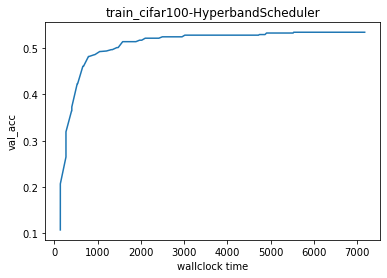

In [11]:
from sagemaker_tune.experiments import load_experiment
from sagemaker_tune.constants import SMT_TUNER_TIME
tuning_experiment = load_experiment(tuner.name)
print(tuning_experiment)
df = tuning_experiment.results.sort_values(SMT_TUNER_TIME)
tuning_experiment.plot()

A lot more of information is also available since all the results obtained over time are stored. For instance, we can plot the metric obtained for each trials over time (recall that 4 trials were running asynchronously).
We clearly see the effect of Hyperband that only lets the trials with best results continue training. This allows to drastically speed-up the tuning.

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


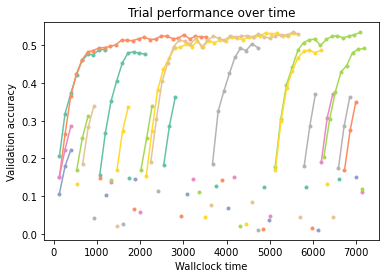

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm

cmap = cm.get_cmap("Set2")
for trial_id in sorted(df.trial_id.unique()):
    dd = df[df.trial_id == trial_id]
    plt.plot(
        dd[SMT_TUNER_TIME],
        dd[tuning_experiment.metric_name()],
        marker='.', color=cmap(trial_id % len(cmap.colors)), label=trial_id
    )
plt.xlabel("Wallclock time")
plt.ylabel("Validation accuracy")
plt.title("Trial performance over time")
plt.savefig('hyperband_long_run_cifar100.png', bbox_inches='tight')

plt.show()

runs_local_backend = df.trial_id.unique().shape[0]

In [ ]:
from sagemaker_tune.optimizer.schedulers.fifo import FIFOScheduler


scheduler = FIFOScheduler(
    config_space,
    searcher='random',
    metric="val_acc",
    mode="max",
)

tuner = Tuner(
    backend=LocalBackend(entry_point="source/train_cifar100.py"),
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(max_wallclock_time=7200),
    n_workers=4,
)

tuner.run()

INFO:sagemaker_tune.optimizer.schedulers.fifo:max_resource_level = 27, as inferred from config_space
INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/train-cifar100-2021-11-15-13-03-08-249
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[0: random]
lr: 0.0010000000000000002
momentum: 0.9
dropout_rate: 0.003162277660168379
INFO:root:Detected 4 GPUs
INFO:root:running subprocess with command: /home/ec2-user/anaconda3/envs/pytorch_p36/bin/python source/train_cifar100.py --epochs 27 --lr 0.0010000000000000002 --momentum 0.9 --dropout_rate 0.003162277660168379 --smt_checkpoint_dir /home/ec2-user/sagemaker-tune/train-cifar100-2021-11-15-13-03-08-249/0/checkpoints
INFO:sagemaker_tune.tuner:(trial 0) - scheduled config {'epochs': 27, 'lr': 0.0010000000000000002, 'momentum': 0.9, 'dropout_rate': 0.003162277660168379}
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[1: random]
lr: 0.00204131331908457

--------------------
Resource summary:
 trial_id      status  iter  epochs        lr  momentum  dropout_rate  epoch  val_acc  worker-time
        0   Completed    27      27  0.001000  0.900000      0.003162   27.0   0.5012       3581.0
        1   Completed    27      27  0.002041  0.893255      0.060172   27.0   0.5050       3555.0
        2   Completed    27      27  0.000103  0.846702      0.071619   27.0   0.4276       3539.0
        3   Completed    27      27  0.076854  0.950995      0.000010   27.0   0.3784       3532.0
        4   Completed    27      27  0.042916  0.949508      0.003727   27.0   0.4202       3540.0
        5   Completed    27      27  0.024870  0.912094      0.000342   27.0   0.5058       3554.0
        6   Completed    27      27  0.000512  0.864119      0.000013   27.0   0.4616       3551.0
        7   Completed    27      27  0.018947  0.845332      0.000012   27.0   0.5404       3585.0
        8  InProgress     0      27  0.042843  0.862833      0.023803 

train-cifar100-2021-11-15-13-03-08-249
Experiment train-cifar100-2021-11-15-13-03-08-249 contains 216 evaluations from 8 trials when tuning val_acc on train_cifar100 with FIFOScheduler.


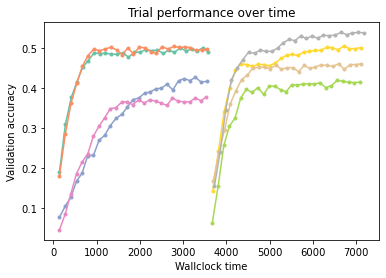

In [ ]:
from sagemaker_tune.experiments import load_experiment
from sagemaker_tune.constants import SMT_TUNER_TIME
print(tuner.name)
tuning_experiment = load_experiment(tuner.name)
print(tuning_experiment)
df = tuning_experiment.results.sort_values(SMT_TUNER_TIME)
# tuning_experiment.plot()

import matplotlib.pyplot as plt
from matplotlib import cm

cmap = cm.get_cmap("Set2")
for trial_id in sorted(df.trial_id.unique()):
    dd = df[df.trial_id == trial_id]
    plt.plot(
        dd[SMT_TUNER_TIME],
        dd[tuning_experiment.metric_name()],
        marker='.', color=cmap(trial_id % len(cmap.colors)), label=trial_id
    )
plt.xlabel("Wallclock time")
plt.ylabel("Validation accuracy")
plt.title("Trial performance over time")
plt.savefig('random_search_long_run_cifar100.png', bbox_inches='tight')
plt.show()

In [ ]:
from sagemaker_tune.optimizer.schedulers.fifo import FIFOScheduler


scheduler = HyperbandScheduler(
    config_space,
    max_t=max_epochs,
    resource_attr='epoch',
    searcher='bayesopt',
    metric="val_acc",
    mode="max",
)

tuner = Tuner(
    backend=LocalBackend(entry_point="source/train_cifar100.py"),
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(max_wallclock_time=7200),
    n_workers=4,
)

tuner.run()

INFO:sagemaker_tune.optimizer.schedulers.searchers.gp_fifo_searcher:[ModelBasedSearcher.__init__]
- acquisition_class = <class 'sagemaker_tune.optimizer.schedulers.searchers.bayesopt.models.meanstd_acqfunc_impl.EIAcquisitionFunction'>
- local_minimizer_class = None
- num_initial_candidates = 250
- num_initial_random_choices = 6
- initial_scoring = thompson_indep

INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/train-cifar100-2021-11-15-15-03-11-002
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[0: random]
lr: 0.0010000000000000002
momentum: 0.9
dropout_rate: 0.003162277660168379
INFO:sagemaker_tune.optimizer.schedulers.hyperband:trial_id 0 starts (first milestone = 1)
INFO:root:Detected 4 GPUs
INFO:root:running subprocess with command: /home/ec2-user/anaconda3/envs/pytorch_p36/bin/python source/train_cifar100.py --epochs 27 --lr 0.0010000000000000002 --momentum 0.9 --dropout_rate 0.003162277660168379 --smt_checkpo

--------------------
Resource summary:
 trial_id      status  iter  epochs        lr  momentum  dropout_rate  epoch  val_acc  worker-time
        0  InProgress     9      27  0.001000  0.900000      0.003162      9   0.4903         1183
        1  InProgress     3      27  0.000715  0.857460      0.051920      3   0.3356          395
        2  InProgress     1      27  0.001223  0.997910      0.276473      1   0.0181          130
        3   Completed    27      27  0.021501  0.834087      0.024321     27   0.5162         3520
        4  InProgress     1      27  0.014830  0.863854      0.000183      1   0.1355          130
        5  InProgress     1      27  0.000061  0.860855      0.447508      1   0.0508          130
        6  InProgress     9      27  0.001681  0.877061      0.008725      9   0.4812         1175
        7  InProgress     1      27  0.000011  0.879917      0.006767      1   0.0281          129
        8  InProgress     1      27  0.000564  0.891312      0.027212 

Experiment train-cifar100-2021-11-15-15-03-11-002 contains 215 evaluations from 45 trials when tuning val_acc on train_cifar100 with HyperbandScheduler.


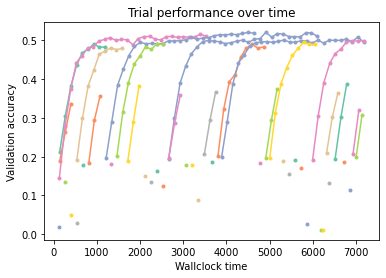

In [ ]:
from sagemaker_tune.experiments import load_experiment
from sagemaker_tune.constants import SMT_TUNER_TIME
tuning_experiment = load_experiment(tuner.name)
print(tuning_experiment)
df = tuning_experiment.results.sort_values(SMT_TUNER_TIME)
# tuning_experiment.plot()

import matplotlib.pyplot as plt
from matplotlib import cm

cmap = cm.get_cmap("Set2")
for trial_id in sorted(df.trial_id.unique()):
    dd = df[df.trial_id == trial_id]
    plt.plot(
        dd[SMT_TUNER_TIME],
        dd[tuning_experiment.metric_name()],
        marker='.', color=cmap(trial_id % len(cmap.colors)), label=trial_id
    )
plt.xlabel("Wallclock time")
plt.ylabel("Validation accuracy")
plt.title("Trial performance over time")
plt.savefig('mobster_long_run_cifar100.png', bbox_inches='tight')
plt.show()

The previous example showed how to tune hyperparameter on a local machine. It can be used to tune your hyperparameters or your own machine for instance. 

Sometimes, we need more powerful machine or a larger number which motivates the use of cloud ressources. In those cases, SageMaker tune provides a very simple way to run tuning on Sagemaker. Let us have a look.

We first upload cifar10 dataset to s3 so that it is available on cloud machines.


In [ ]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-cnn-cifar100"
role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix="data/cifar100")

We now define our new backend to specify that we want trials to be executed on SageMaker. 
We use SageMaker framework (`PyTorch`) in this particular example since we have a pytorch training script but any SageMaker framework can be used (XGBoost, TensorFlow, SKlearn, HuggingFace, ...). 

If you do not know what a SageMaker framework is, it is a Python wrapper that allows you to run Machine Learning code easily by providing pre-made docker images that works seamlessly on CPU and GPU for many framework versions. In this particular example for instance, all we need to do is to instantiate the wrapper PyTorch with our training script.

In [ ]:
from sagemaker.pytorch import PyTorch
from sagemaker_tune.backend.sagemaker_backend.sagemaker_utils import get_execution_role
from sagemaker_tune.backend.sagemaker_backend.sagemaker_backend import SagemakerBackend

backend = SagemakerBackend(
    sm_estimator=PyTorch(
        entry_point="./source/train_cifar100.py",
        instance_type="ml.g4dn.xlarge",
        instance_count=1,
        role=get_execution_role(),
        framework_version='1.7.1',
        py_version='py3',
    ),
    inputs=inputs,
)


INFO:sagemaker_tune.backend.sagemaker_backend.sagemaker_utils:No Sagemaker role passed as environment variable $AWS_ROLE, inferring it.


In [ ]:
scheduler = HyperbandScheduler(
    config_space,
    max_t=max_epochs,
    resource_attr='epoch',
    searcher='random',
    metric="val_acc",
    mode="max",
)


We can now run again our tuning, this time we use 20 workers each having its own GPU. 

In [ ]:
tuner = Tuner(
    backend=backend,
    scheduler=scheduler,
    stop_criterion=StoppingCriterion(max_wallclock_time=7200, max_cost=20.0),
    n_workers=20,
    tuner_name="cifar100-on-sagemaker"
)

tuner.run()


INFO:sagemaker_tune.tuner:results of trials will be saved on /home/ec2-user/sagemaker-tune/cifar100-on-sagemaker-2021-11-15-17-03-18-306
INFO:sagemaker_tune.optimizer.schedulers.searchers.bayesopt.utils.debug_log:[0: random]
lr: 0.0010000000000000002
momentum: 0.9
dropout_rate: 0.003162277660168379
INFO:sagemaker_tune.optimizer.schedulers.hyperband:trial_id 0 starts (first milestone = 1)
INFO:root:Trial 0 will checkpoint results to s3://sagemaker-us-west-2-770209394645/sagemaker-tune/cifar100-on-sagemaker-2021-11-15-17-03-18-306/0/.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cifar100-on-sagemaker-2021-11-15-17-03-18-306-0
INFO:sagemaker_tune.backend.sagemaker_backend.sagemaker_backend:scheduled cifar100-on-sagemaker-2021-11-15-17-03-18-306-0 for trial-id 0
INFO:sagemaker_tune.tuner:(trial 0) - scheduled config {'epochs'

After the instance starts their training, you will see the status update as in the local case.
An important difference is that the total estimated dollar-cost is displayed as well the cost of workers.


```
trial_id      status  iter  dropout_rate  epochs        lr  momentum  epoch  val_acc  worker-time  worker-cost
        0  InProgress     1      0.003162      30  0.001000  0.900000    1.0   0.4518         50.0     0.010222
        1  InProgress     1      0.037723      30  0.000062  0.843500    1.0   0.1202         50.0     0.010222
        2  InProgress     1      0.000015      30  0.000865  0.821807    1.0   0.4121         50.0     0.010222
        3  InProgress     1      0.298864      30  0.006991  0.942469    1.0   0.2283         49.0     0.010018
        4  InProgress     0      0.000017      30  0.028001  0.911238      -        -            -            -
        5  InProgress     0      0.000144      30  0.000080  0.870546      -        -            -            -
6 trials running, 0 finished (0 until the end), 387.53s wallclock-time, 0.04068444444444444$ estimated cost
```

Since we specified `max_wallclock_time=3600` and `max_cost=20.0`, the tuning will stops when the wallclock time or estimated cost goes above the bound. In addition to providing a sense of the spending, the cost can also be optimized with our multiobjective optimizers, see this [link](https://github.com/awslabs/sagemaker-tune/blob/main/examples/launch_moasha_instance_tuning.py) for an example.

Finally, we can plot the performance obtained in the same way as for the local case.


In [ ]:
tuning_experiment = load_experiment(tuner.name)
tuning_experiment.plot()

In [ ]:
from sagemaker_tune.experiments import load_experiment
from sagemaker_tune.constants import SMT_TUNER_TIME
tuning_experiment = load_experiment(tuner.name)
print(tuning_experiment)
df = tuning_experiment.results.sort_values(SMT_TUNER_TIME)
# tuning_experiment.plot()

import matplotlib.pyplot as plt
from matplotlib import cm

cmap = cm.get_cmap("Set2")
for trial_id in sorted(df.trial_id.unique()):
    dd = df[df.trial_id == trial_id]
    plt.plot(
        dd[SMT_TUNER_TIME],
        dd[tuning_experiment.metric_name()],
        marker='.', color=cmap(trial_id % len(cmap.colors)), label=trial_id
    )
plt.xlabel("Wallclock time")
plt.ylabel("Validation accuracy")
plt.title("Trial performance over time")
plt.savefig('sagemakerbackend_long_run_cifar100.png', bbox_inches='tight')
plt.show()

runs_sagemaker_backend = df.trial_id.unique().shape[0]

In [ ]:
print(runs_sagemaker_backend)
print(runs_local_backend)

plt.bar(0, runs_local_backend)
plt.bar(1, runs_sagemaker_backend)

plt.xticks([0, 1], ['local backend', 'sagemaker backend'])
plt.xlabel("Backend")
plt.ylabel("number of trials")
plt.title("Number of trial evaluated")
plt.savefig('comparison_backend_long_run_cifar100.png', bbox_inches='tight')
plt.show()
